<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
<center>Автор материала: Ольга Дайховская

# <center> Домашнее задание № 4. Часть 2
## <center>  Прогнозирование популярности статей на TechMedia с помощью линейных моделей

**В задании Вам предлагается разобраться с тем, как работает TfidfVectorizer и DictVectorizer, затем обучить и настроить модель линейной регрессии Ridge на данных о публикациях на Хабрахабре. Пройдя все шаги, вы сможете получить бейзлайн для [соревнования](https://inclass.kaggle.com/c/howpop-habrahabr-favs-lognorm). 
Ответьте на все вопросы в этой тетрадке и заполните ответы в [гугл-форме](https://docs.google.com/forms/d/e/1FAIpQLSd8E7naU38ikc9-rd31KeVfez3emCo4Ok1WrpQTr-XCDelRiw/viewform).**

**Описание соревнования**

Предскажите, как много звездочек наберет статья, зная только ее текст и время публикации

Необходимо предсказать популярность поста на Хабре по содержанию и времени публикации. Как известно, пользователи Хабра могут добавлять статьи к себе в избранное. Общее количество пользователей, которое это сделали отображается у статьи количеством звездочек. Будем считать, что число звездочек, поставленных статье, наиболее хорошо отражает ее популярность.

Более формально, в качестве метрики популярности статьи будем использовать долю статей за последний месяц, у которых количество звездочек меньше чем у текущей статьи. А точнее, доле числа звездочек можно поставить в соответствие квантили стандартного распределения, таким образом получаем числовую характеристику популярности статьи. Популярность статьи 0 означает, что статья получила ровно столько звездочек, сколько в среднем получают статьи. И соответственно чем больше звездочек получила статья по сравнению со средним, тем выше это число.

**Приступим:** импортируем необходимые библиотеки и скачаем данные

In [1]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer

#В зависимости от версии sklearn
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

import numpy as np
import scipy

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
train_df = pd.read_csv('habr_data/howpop_train.csv')
test_df  = pd.read_csv('habr_data/howpop_test.csv')

In [3]:
train_df.head(1).T

,0
url,https://habrahabr.ru/post/18284/
domain,habrahabr.ru
post_id,18284
published,2008-01-01 18:19:00
author,@Tapac
flow,develop
polling,False
content_len,4305
title,Новогодний подарок блоггерам — WordPress 2.3.2
comments,0


In [4]:
train_df.shape, test_df.shape

((134137, 17), (3990, 9))

Убедимся, что данные отсортированы по признаку `published`

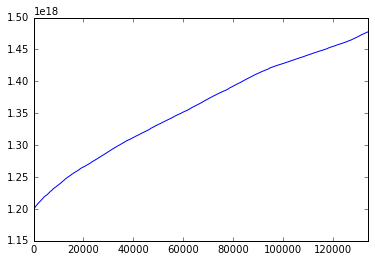

In [5]:
train_df['published'].apply(lambda ts: pd.to_datetime(ts).value).plot();

**Чтобы ответить на вопросы 1 и 2, можно использовать [pandas.DataFrame.corr()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html), [pandas.to_datetime()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html) и [pandas.Series.value_counts()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.value_counts.html)**

<font color='red'>Вопрос 1.</font> Есть ли в train_df признаки, корреляция между которыми больше 0.9? Обратите внимание, именно различные признаки - корреляция признака с самим собой естественно больше 0.9 :)
- да
- нет
- не знаю

In [6]:
train_df.corr() > 0.9

,post_id,polling,content_len,comments,favs,views,votes_plus,votes_minus,views_lognorm,favs_lognorm,comments_lognorm
post_id,True,False,False,False,False,False,False,False,False,False,False
polling,False,True,False,False,False,False,False,False,False,False,False
content_len,False,False,True,False,False,False,False,False,False,False,False
comments,False,False,False,True,False,False,False,False,False,False,False
favs,False,False,False,False,True,False,False,False,False,False,False
views,False,False,False,False,False,True,False,False,False,False,False
votes_plus,False,False,False,False,False,False,True,False,False,False,False
votes_minus,False,False,False,False,False,False,False,True,False,False,False
views_lognorm,False,False,False,False,False,False,False,False,True,False,False
favs_lognorm,False,False,False,False,False,False,False,False,False,True,False


<font color='red'>Вопрос 2.</font> В каком году было больше всего публикаций? (Рассматриваем train_df)
- 2014
- 2015
- 2016
- 2017

In [7]:
train_df.published = pd.to_datetime(train_df.published)
train_df.published.apply(lambda x: x.year).value_counts()

2015    23452
2016    16316
2014    16180
2012    15972
2013    15537
2011    15063
2010    13091
2009    10783
2008     7743
Name: published, dtype: int64

## Разбиение на train/valid
Используем только признаки 'author', 'flow', 'domain' и 'title'

In [8]:
features = ['author', 'flow', 'domain', 'title']
train_size = int(0.7 * train_df.shape[0])

In [9]:
len(train_df),train_size

(134137, 93895)

In [10]:
X, y = train_df.ix[:, features],  train_df['favs_lognorm'] #отделяем признаки от целевой переменной

X_test = test_df.ix[:, features]

In [11]:
X_train, X_valid = X.iloc[:train_size, :], X.iloc[train_size:,:]

y_train, y_valid = y.iloc[:train_size], y.iloc[train_size:]

## Применение TfidfVectorizer

**TF-IDF** (от англ. TF — term frequency, IDF — inverse document frequency) — статистическая мера, используемая для оценки важности слова в контексте документа, являющегося частью коллекции документов или корпуса. Вес некоторого слова пропорционален количеству употребления этого слова в документе, и обратно пропорционален частоте употребления слова в других документах коллекции. [Подробнее в источнике](https://ru.wikipedia.org/wiki/TF-IDF)

TfidfVectorizer преобразует тексты в матрицу TF-IDF признаков.

**Основные параметры TfidfVectorizer в sklearn:**
- **min_df** - при построении словаря слова, которые встречаются *реже*, чем указанное значение, игнорируются
- **max_df** - при построении словаря слова, которые встречаются *чаще*, чем указанное значение, игнорируются
- **analyzer** - определяет, строятся ли признаки по словам или по символам (буквам)
- **ngram_range** - определяет, формируются ли признаки только из отдельных слов или из нескольких слов (в случае с analyzer='char' задает количество символов). Например, если указать analyzer='word' и ngram_range=(1,3),то признаки будут формироваться из отдельных слов, из пар слов и из троек слов.
- **stop_words** - слова, которые игнорируются при построении матрицы

Более подробно с параметрами можно ознакомиться в [документации](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

**Инициализируйте TfidfVectorizer с параметрами min_df=3, max_df=0.3 и ngram_range=(1, 3).<br />
Примените метод fit_transform к X_train['title'] и метод transform к X_valid['title'] и X_test['title']**

<font color='red'>Вопрос 3.</font> Какой размер у полученного словаря?
- 43789
- 50624
- 93895
- 74378

In [12]:
vectorizer_title = TfidfVectorizer(min_df=3, max_df=0.3, ngram_range=(1, 3))

X_train_title = vectorizer_title.fit_transform(X_train['title'])
X_valid_title = vectorizer_title.transform(X_valid['title'])
X_test_title = vectorizer_title.transform(X_test['title'])

In [13]:
#Можно посмотреть словарь в виде {'термин': индекс признака,...}
len(vectorizer_title.vocabulary_)

50624

In [14]:
vectorizer_title.vocabulary_["python"]

9065

<font color='red'>Вопрос 4.</font> Какой индекс у слова 'python'?
- 1
- 10
- 9065
- 15679

In [15]:
#ваш код здесь

**Инициализируйте TfidfVectorizer, указав analyzer='char'.<br />
Примените метод fit_transform к X_train['title'] и метод transform к X_valid['title'] и X_test['title']**

<font color='red'>Вопрос 5.</font> Какой размер у полученного словаря?
- 218
- 510
- 125
- 981

In [16]:
vectorizer_title_ch = TfidfVectorizer(analyzer="char")

X_train_title_ch = vectorizer_title_ch.fit_transform(X_train['title'])
X_valid_title_ch = vectorizer_title_ch.transform(X_valid['title'])
X_test_title_ch = vectorizer_title_ch.transform(X_test['title'])

In [17]:
#Здесь так же можно посмотреть словарь
#Заметьте насколько отличаются словари для TfidfVectorizer с analyzer='word' и analyzer='char'
len(vectorizer_title_ch.vocabulary_)

218

In [18]:
vectorizer_title_ch.vocabulary_

{u' ': 0,
 u'!': 1,
 u'"': 2,
 u'#': 3,
 u'$': 4,
 u'%': 5,
 u'&': 6,
 u"'": 7,
 u'(': 8,
 u')': 9,
 u'*': 10,
 u'+': 11,
 u',': 12,
 u'-': 13,
 u'.': 14,
 u'/': 15,
 u'0': 16,
 u'1': 17,
 u'2': 18,
 u'3': 19,
 u'4': 20,
 u'5': 21,
 u'6': 22,
 u'7': 23,
 u'8': 24,
 u'9': 25,
 u':': 26,
 u';': 27,
 u'<': 28,
 u'=': 29,
 u'>': 30,
 u'?': 31,
 u'@': 32,
 u'[': 33,
 u'\\': 34,
 u']': 35,
 u'^': 36,
 u'_': 37,
 u'`': 38,
 u'a': 39,
 u'b': 40,
 u'c': 41,
 u'd': 42,
 u'e': 43,
 u'f': 44,
 u'g': 45,
 u'h': 46,
 u'i': 47,
 u'j': 48,
 u'k': 49,
 u'l': 50,
 u'm': 51,
 u'n': 52,
 u'o': 53,
 u'p': 54,
 u'q': 55,
 u'r': 56,
 u's': 57,
 u't': 58,
 u'u': 59,
 u'v': 60,
 u'w': 61,
 u'x': 62,
 u'y': 63,
 u'z': 64,
 u'{': 65,
 u'|': 66,
 u'}': 67,
 u'~': 68,
 u'\x92': 69,
 u'\x97': 70,
 u'\xa0': 71,
 u'\xa3': 72,
 u'\xa5': 73,
 u'\xa7': 74,
 u'\xa9': 75,
 u'\xab': 76,
 u'\xad': 77,
 u'\xae': 78,
 u'\xb0': 79,
 u'\xb1': 80,
 u'\xb2': 81,
 u'\xb5': 82,
 u'\xb7': 83,
 u'\xb9': 84,
 u'\xbb': 85,
 u'\xbc': 86

## Работа с категориальными признаками

Для обработки категориальных признаков 'author', 'flow', 'domain' мы будем использовать DictVectorizer из sklearn.

In [19]:
feats = ['author', 'flow', 'domain']
X_train[feats][:5]

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,NaN,geektimes.ru


Рассмотрим как он работает на примере первых пяти строк

In [20]:
#сначала заполняем пропуски прочерком
X_train[feats][:5].fillna('-')

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,-,geektimes.ru


In [21]:
#Преобразуем датафрейм в словарь, где ключами являются индексы объектов (именно для этого мы транспонировали датафрейм),
#а значениями являются словари в виде 'название_колонки':'значение'
X_train[feats][:5].fillna('-').T.to_dict()

{0: {'author': '@Tapac', 'domain': 'habrahabr.ru', 'flow': 'develop'},
 1: {'author': '@DezmASter', 'domain': 'habrahabr.ru', 'flow': 'design'},
 2: {'author': '@DezmASter', 'domain': 'habrahabr.ru', 'flow': 'design'},
 3: {'author': '@Taoorus', 'domain': 'habrahabr.ru', 'flow': 'design'},
 4: {'author': '@dennydo', 'domain': 'geektimes.ru', 'flow': '-'}}

In [22]:
# В DictVectorizer нам нужно будет передать список словарей для каждого объекта в виде 'название_колонки':'значение',
#поэтому используем .values()
X_train[feats][:5].fillna('-').T.to_dict().values()

[{'author': '@Tapac', 'domain': 'habrahabr.ru', 'flow': 'develop'},
 {'author': '@DezmASter', 'domain': 'habrahabr.ru', 'flow': 'design'},
 {'author': '@DezmASter', 'domain': 'habrahabr.ru', 'flow': 'design'},
 {'author': '@Taoorus', 'domain': 'habrahabr.ru', 'flow': 'design'},
 {'author': '@dennydo', 'domain': 'geektimes.ru', 'flow': '-'}]

In [23]:
#В итоге получается разреженная матрица
dict_vect = DictVectorizer()
dict_vect_matrix = dict_vect.fit_transform(X_train[feats][:5].fillna('-').T.to_dict().values())
dict_vect_matrix

<5x9 sparse matrix of type '<type 'numpy.float64'>'
	with 15 stored elements in Compressed Sparse Row format>

In [24]:
#Но можно преобразовать ее в numpy array с помощью .toarray()
dict_vect_matrix.toarray()

array([[ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.]])

In [25]:
#В получившейся матрице 5 строк (по числу объектов) и 9 столбцов
#Далее разберемся почему колонок именно 9
dict_vect_matrix.shape

(5, 9)

Посмотрим сколько уникальных значений в каждой колонке.<br />
Суммарно их 9 - столько же, сколько и колонок. Это объясняется тем, что для категориальных признаков со строковыми значениями DictVectorizer делает кодирование бинарными признаками - каждому уникальному значению признака соответствует один новый бинарный признак, который равен 1 только в том случае, если в исходной матрице этот признак принимает значение, которому соответствует эта колонка новой матрицы.

In [26]:
for col in feats:
    print(col,len(X_train[col][:5].fillna('-').unique()))

('author', 4)
('flow', 3)
('domain', 2)


Также можно посмотреть что означает каждая колонка полученной матрицы

In [27]:
#например, самая первая колонка называется 'author=@DezmASter' - то есть принимает значение 1 только если автор @DezmASter
dict_vect.feature_names_

['author=@DezmASter',
 'author=@Taoorus',
 'author=@Tapac',
 'author=@dennydo',
 'domain=geektimes.ru',
 'domain=habrahabr.ru',
 'flow=-',
 'flow=design',
 'flow=develop']

**Инициализируйте DictVectorizer с параметрами по умолчанию.
Примените метод fit_transform к признакам 'author', 'flow', 'domain' X_train и метод transform к тем же признакам X_valid и X_test**

In [28]:
vectorizer_feats = DictVectorizer()

X_train_feats = vectorizer_feats.fit_transform(X_train[['author', 'flow', 'domain' ]].fillna('-').T.to_dict().values())
X_valid_feats = vectorizer_feats.transform(X_valid[['author', 'flow', 'domain' ]].fillna('-').T.to_dict().values())
X_test_feats = vectorizer_feats.transform(X_test[['author', 'flow', 'domain' ]].fillna('-').T.to_dict().values())

In [29]:
X_train_feats.shape

(93895, 17869)

Соединим все полученные матрицы при помощи scipy.sparse.hstack()

In [30]:
X_train_new = scipy.sparse.hstack([X_train_title, X_train_feats, X_train_title_ch])
X_valid_new = scipy.sparse.hstack([X_valid_title, X_valid_feats, X_valid_title_ch])
X_test_new =  scipy.sparse.hstack([X_test_title, X_test_feats, X_test_title_ch])

## Обучение модели

Далее будем использовать Ridge, линейную модель с l2-регуляризацией.
[Документация](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

Основной параметр Ridge - **alpha, коэффициент регуляризации**. Регуляризация используется для улучшения обобщающей способности модели - прибавляя к функционалу потерь сумму квадратов весов, умноженную на коэффициент регуляризации (та самая alpha), мы штрафуем модель за слишком большие значения весов и не позволяем ей переобучаться. Чем больше этот коээфициент, тем сильнее эффект.

**Обучите две модели на X_train_new, y_train, задав в первой alpha=0.1 и random_state = 1, а во второй alpha=1.0 и random_state = 1**

**Рассчитайте среднеквадратичную ошибку каждой модели (mean_squared_error). Сравните значения ошибки на обучающей и тестовой выборках и ответьте на вопросы.**

<font color='red'>Вопрос 6.</font> Выберите верные утверждения:
- обе модели показывают одинаковый результат (среднеквадратичная ошибка отличается не больше чем на тысячные), регуляризация ничего не меняет
- при alpha=0.1 модель переобучается
- среднеквадратичная ошибка первой модели на тесте меньше
- при alpha=1.0 у модели обощающая способность лучше, чем у при alpha=0.1

In [63]:
%%time
model1 = Ridge(alpha=4.0, random_state = 1)
model1.fit(X_train_new, y_train)

CPU times: user 7.79 s, sys: 161 ms, total: 7.95 s
Wall time: 8.04 s


In [64]:
train_preds1 = model1.predict(X_train_new)
valid_preds1 = model1.predict(X_valid_new)

print u'Ошибка на трейне', mean_squared_error(y_train, train_preds1)
print u'Ошибка на тесте', mean_squared_error(y_valid, valid_preds1)

Ошибка на трейне 0.409177773443
Ошибка на тесте 0.79925982079


In [66]:
%%time
model2 = Ridge(alpha=4.0, fit_intercept=False, random_state = 1)
model2.fit(X_train_new, y_train)

CPU times: user 2.84 s, sys: 82.9 ms, total: 2.92 s
Wall time: 2.14 s


In [67]:
train_preds2 = model2.predict(X_train_new)
valid_preds2 = model2.predict(X_valid_new)

print u'Ошибка на трейне', mean_squared_error(y_train, train_preds2)
print u'Ошибка на тесте', mean_squared_error(y_valid, valid_preds2)

Ошибка на трейне 0.409416508065
Ошибка на тесте 0.799228999798


## Baseline

**Теперь попытаемся получить бейзлайн для соревования - используйте Ridge с параметрами по умолчанию и обучите модель на всех данных - соедините X_train_new X_valid_new (используйте scipy.sparse.vstack()), а целевой переменной будет y.**

In [43]:
from sklearn.model_selection import GridSearchCV

In [60]:
model = Ridge()
parameters = {'alpha':np.arange(4,4.1,0.01)}

gcv = GridSearchCV(model, param_grid=parameters, n_jobs=-1, cv=3, verbose=1000)

In [61]:
%%time
gcv.fit(scipy.sparse.vstack([X_train_new, X_valid_new]), y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Pickling array (shape=(134138,), dtype=int32).
Memmaping (shape=(4529189,), dtype=int32) to new file /var/folders/cb/klp2b1n941s2d21364cg5kw40000gp/T/joblib_memmaping_pool_72153_4968335248/72153-4817553808-f2753ddb5135001f1df76a8b39109afb.pkl
Memmaping (shape=(4529189,), dtype=float64) to new file /var/folders/cb/klp2b1n941s2d21364cg5kw40000gp/T/joblib_memmaping_pool_72153_4968335248/72153-4817553808-1334f304c123afaf203aa3ce6c048b79.pkl
Memmaping (shape=(134137,), dtype=float64) to new file /var/folders/cb/klp2b1n941s2d21364cg5kw40000gp/T/joblib_memmaping_pool_72153_4968335248/72153-4817553808-5326a935cc5eb6adc48e90c0692f6ca2.pkl
Pickling array (shape=(89424,), dtype=int64).
Pickling array (shape=(44713,), dtype=int64).
Pickling array (shape=(134138,), dtype=int32).
Memmaping (shape=(4529189,), dtype=int32) to old file /var/folders/cb/klp2b1n941s2d21364cg5kw40000gp/T/joblib_memmaping_pool_72153_4968335248/72153-4817553808-f27

GridSearchCV(cv=3, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'alpha': array([ 4.  ,  4.01,  4.02,  4.03,  4.04,  4.05,  4.06,  4.07,  4.08,  4.09])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1000)

In [62]:
gcv.best_params_

{'alpha': 4.0}

In [68]:
%%time
model = Ridge(alpha=4, fit_intercept=False)

model.fit(scipy.sparse.vstack([X_train_new, X_valid_new]), y)

test_preds = model.predict(X_test_new)

CPU times: user 5.01 s, sys: 159 ms, total: 5.17 s
Wall time: 2.84 s


In [69]:
sample_submission = pd.read_csv('habr_data/sample_submission.csv', index_col='url')

In [70]:
test_preds

array([ 0.40144074, -0.437396  ,  0.53324726, ...,  0.56778979,
        0.01722013,  0.41498996])

In [71]:
sample_submission.head()

,favs_lognorm
url,
https://habrahabr.ru/post/314080/,0.323588
https://habrahabr.ru/company/plesk/blog/313732/,0.560105
https://habrahabr.ru/company/etagi/blog/314000/,0.667039
https://habrahabr.ru/company/knopka/blog/314030/,0.149563
https://geektimes.ru/company/audiomania/blog/282058/,0.670754


In [72]:
ridge_submission = sample_submission.copy()
ridge_submission['favs_lognorm'] = test_preds
ridge_submission.to_csv('ridge_baseline_alpha_4.0.csv') #а вот и бейзлайн